## 0. Load datasets

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      classifier )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=None)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    

In [2]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))


668


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_2844/2752992110.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)


## 1. Predict from mother division frame

In [10]:
# Run classifier
# axis0: observation axis1: prediction

feature2predict = 'At least one daughter differentiated'
divisions = divisions.dropna(subset=[(feature2predict,'Meta')])
print(len(divisions))
predictions,models = predict_feature(divisions,
                                     ensemble.RandomForestClassifier(random_state=None),
                                     feature2predict,Niter=10000)


303


100%|█████████████████████████████████████████| 10000/10000 [15:41<00:00, 10.62it/s]


0.621132405115622


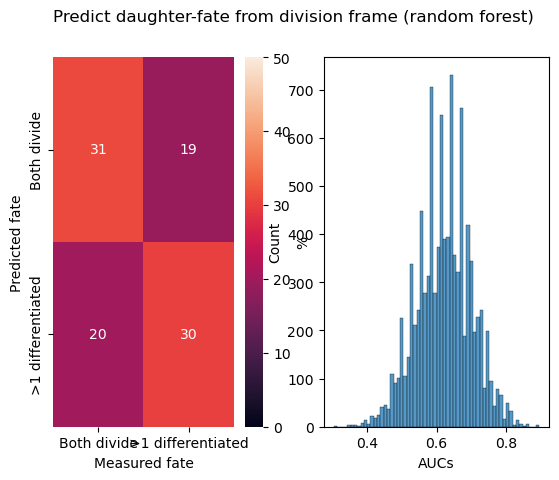

In [11]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.subplot(1,2,1)
# sb.set(font_scale=1)  # crazy big
# plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.subplot(1,2,2)
sb.histplot(AUCs)
plt.xlabel('AUCs')

plt.suptitle('Predict daughter-fate from division frame (random forest)')
print(AUCs.mean())

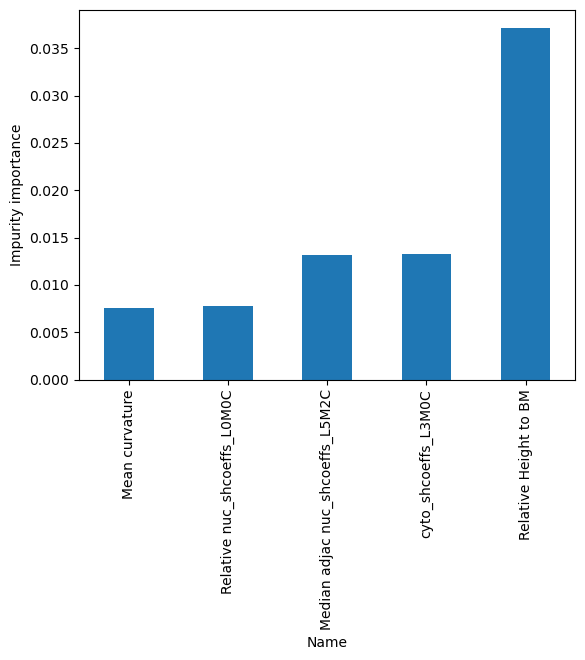

In [13]:
feat_names = divisions.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(5).plot.bar()

plt.ylabel('Impurity importance')

model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Random_forest_division'
importances.mean().sort_values().to_csv(path.join(model_dir,'importances.csv'))

## Vary forest parameters

  0%|                                                   | 0/100 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
  4%|█▋                                         | 4/100 [00:00<00:02, 33.12it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This pr

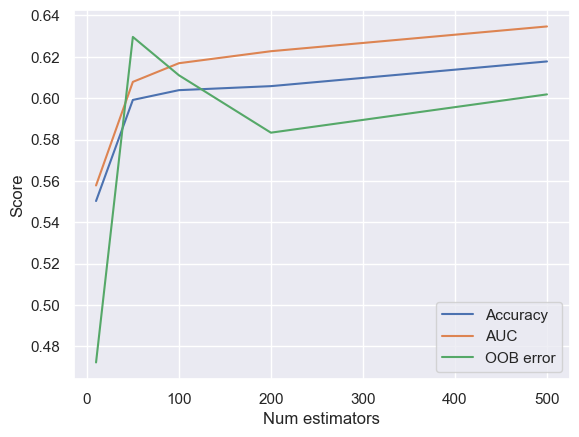

In [154]:
# Number of estimators
scores = pd.DataFrame(index=[10,50,100,200,500],columns=['Accuracy','AUC','OOB error'])
for num_trees in scores.index.values:
    predictions,models = predict_feature(divisions,
                                         ensemble.RandomForestClassifier(n_estimators = num_trees,oob_score=True),
                                         feature2predict,Niter=100)
    scores.loc[num_trees,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[num_trees,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[num_trees,'OOB error'] = np.array([m[1].oob_score_ for m in models]).mean()

plt.plot(scores)
plt.xlabel('Num estimators')
plt.ylabel('Score')
plt.legend(['Accuracy','AUC','OOB error'])

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.62it/s]
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_5927/3407642232.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


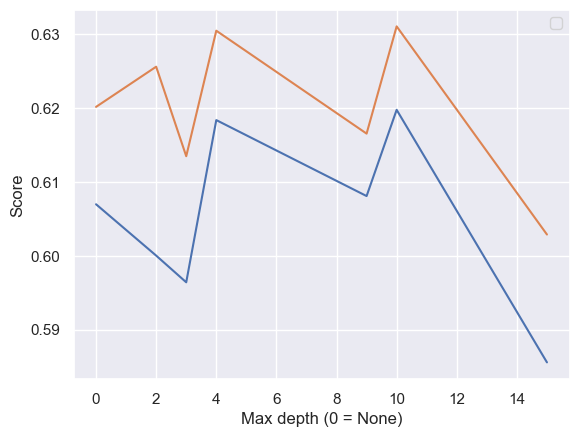

In [146]:
# Vary the depth with num_tree = 100
# Number of estimators
scores = pd.DataFrame(index=[0,2,3,4,9,10,15],columns=['Accuracy','AUC'])
for max_depth in scores.index.values:
    if max_depth == 0:
        max_depth_ = None
    else:
        max_depth_ = int(max_depth)
    predictions,models = predict_feature(divisions,
                                         ensemble.RandomForestClassifier(n_estimators = 100,max_depth=max_depth_),
                                         feature2predict,Niter=100)
    scores.loc[max_depth,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[max_depth,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()

plt.plot(scores)
plt.xlabel('Max depth (0 = None)')
plt.ylabel('Score')
plt.legend()

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.24it/s]
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_5927/2030959459.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


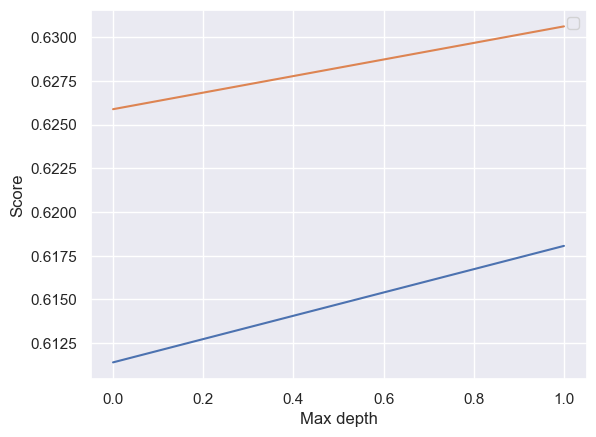

In [145]:
# Quantify out of bag error
# Vary the depth with num_tree = 100
# Number of estimators
scores = pd.DataFrame(index=[True,False],columns=['Accuracy','AUC'])
for oob in scores.index.values:
    predictions,models = predict_feature(divisions,
                                         ensemble.RandomForestClassifier(n_estimators = 100,oob_score=oob),
                                         feature2predict,Niter=100)
    scores.loc[oob,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[oob,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()

plt.plot(scores)
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.legend()

### Feature selection

(np.float64(3.8583695555936277), np.float64(0.00013967259657899196))


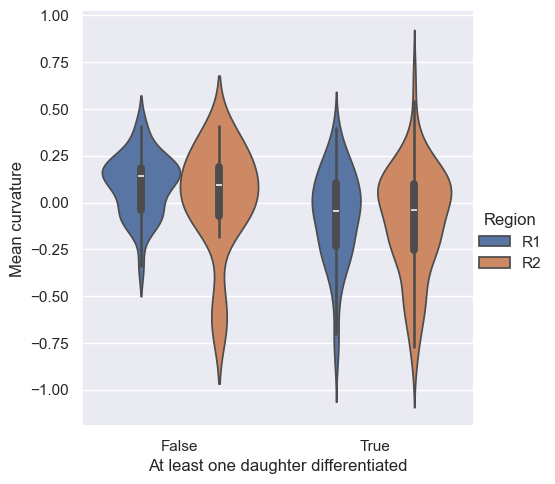

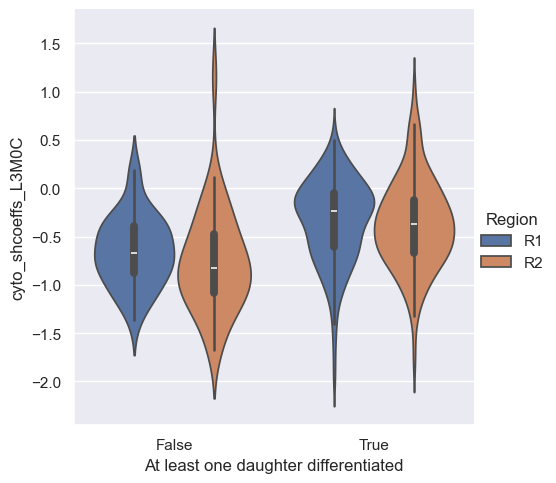

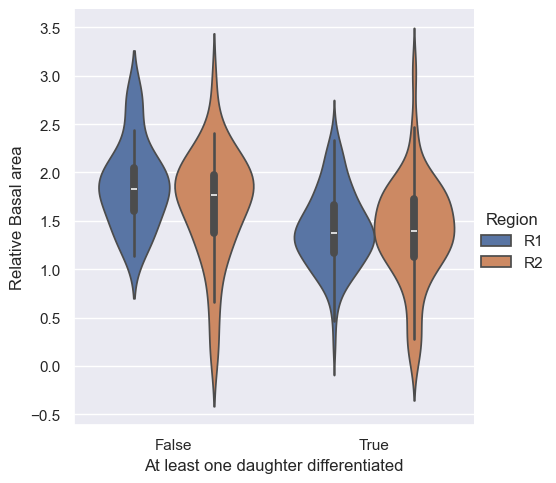

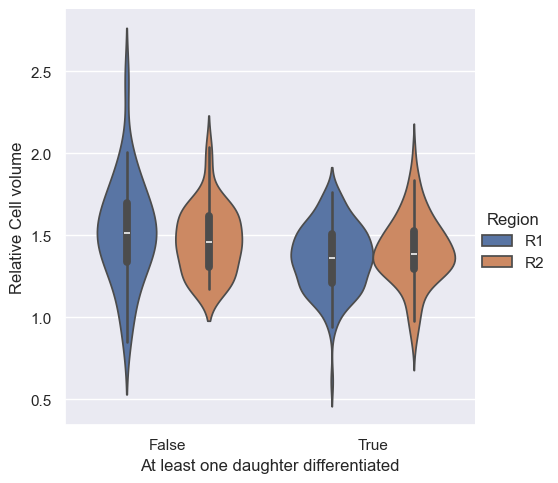

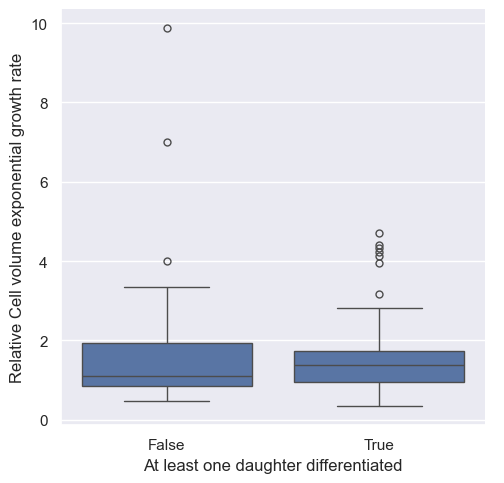

In [156]:
from basicUtils import ttest_from_groupby
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Mean curvature',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L3M0C',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Basal area',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Cell volume',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Cell volume exponential growth rate',kind='box')
print(ttest_from_groupby(divisions.droplevel(axis=1,level=1),field2group=feature2predict,field2test='Mean curvature'))



## Subset top 50 features

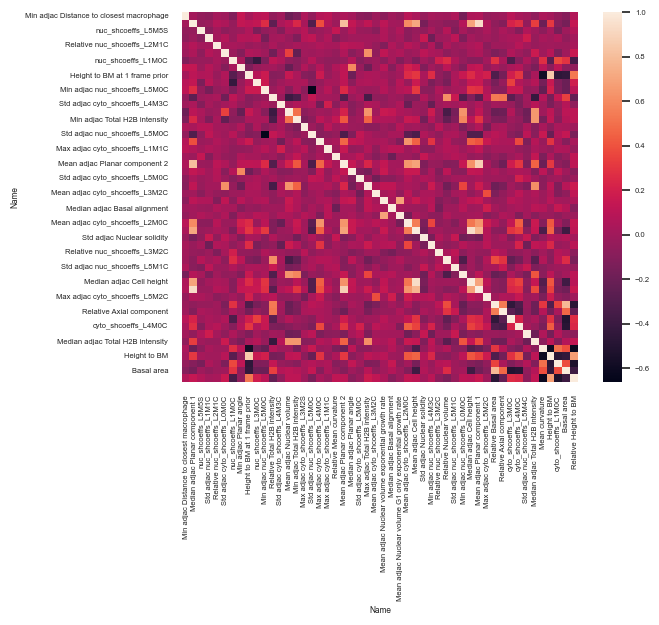

In [11]:
# Take top 50 features by importance and see their correlation matrix

top50feats = importances.mean().sort_values().dropna().tail(50).index
C50 = divisions.droplevel(axis=1,level=1)[top50feats].corr()

sb.set(font_scale=0.5)  # crazy big
sb.heatmap(C50)
C50.index.name = 'Feature1'
C50.columns.name = 'Feature2'
C50 = C50.stack().reset_index().sort_values(by=0)
C50 = C50[C50[0] < 1]
# C50.tail(100)

In [15]:
# linear model

from sklearn.linear_model import LogisticRegression

top50 = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[top50feats]
top50.columns = pd.MultiIndex.from_product([top50.columns,['Measurement']])
top50[(feature2predict,'Meta')] = divisions[feature2predict,'Meta']

top50 = top50.dropna()

predictions,models = predict_feature(top50, LogisticRegression(), feature2predict,Niter=1000)


100%|██████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.50it/s]


0.6404335381272495


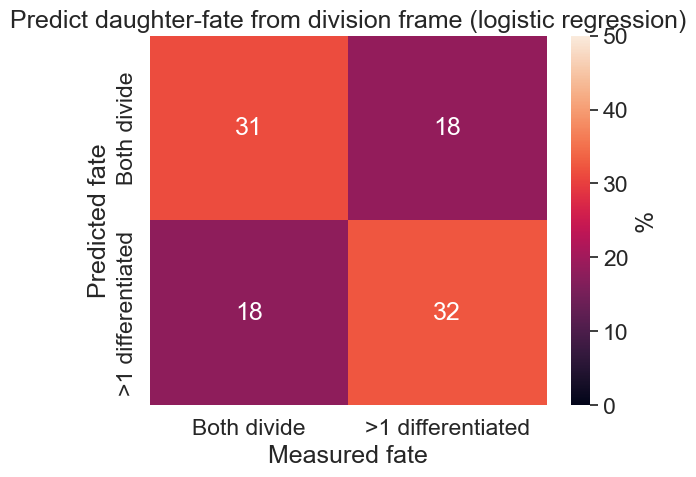

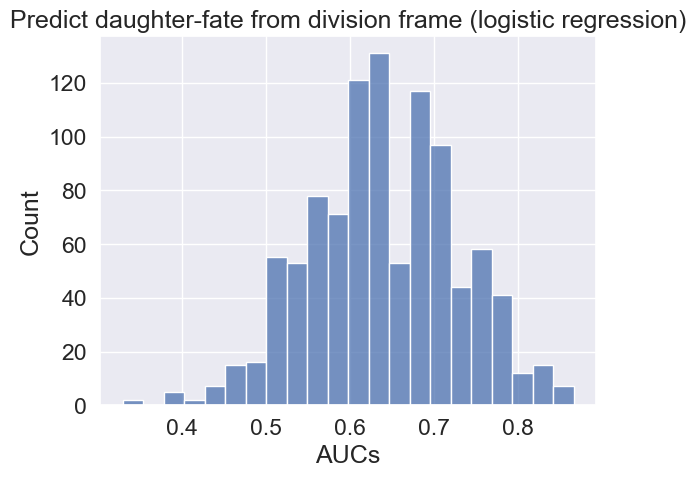

In [16]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1.5)  # crazy big
plt.title('Predict daughter-fate from division frame (logistic regression)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (logistic regression)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

print(AUCs.mean())

In [20]:
linear_importances['Mean curvature']

0      0.045532
1      0.045532
2      0.045532
3      0.045532
4      0.045532
         ...   
995    0.045532
996    0.045532
997    0.045532
998    0.045532
999    0.045532
Name: Mean curvature, Length: 1000, dtype: float64

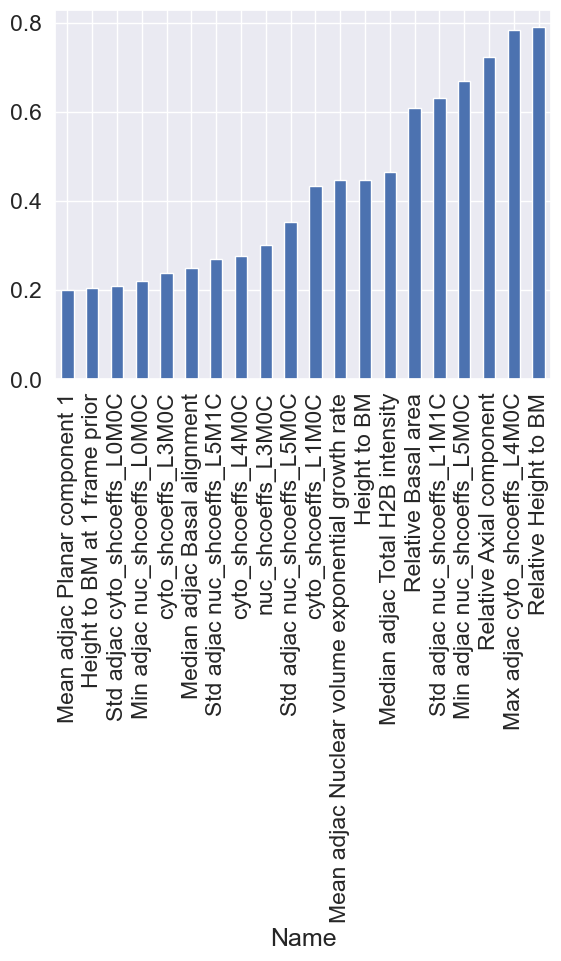

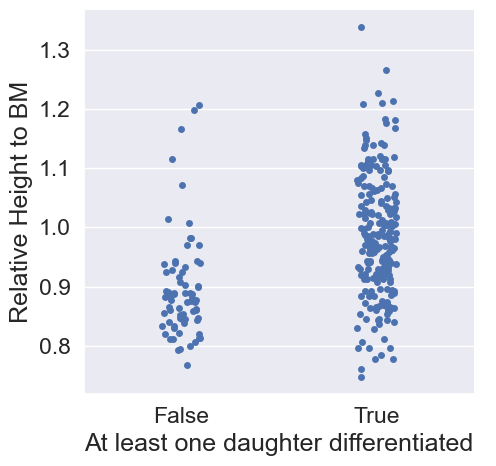

In [18]:

linear_importances = pd.DataFrame( [np.squeeze(m[1].coef_) for m in models],columns=top50.xs('Measurement',level=1,axis=1).columns)

linear_importances.mean().sort_values().tail(20).plot.bar()

sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Height to BM')

<Axes: xlabel='Relative Height to BM', ylabel='At least one daughter differentiated'>

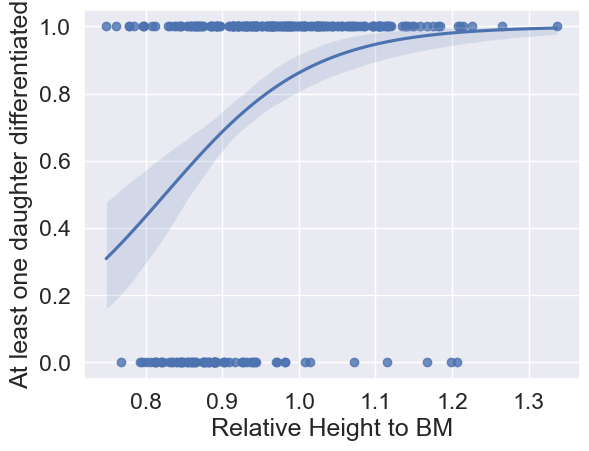

In [169]:
x = 'Relative Height to BM'
sb.regplot(divisions.droplevel(axis=1,level=1)[[x,feature2predict]].astype(float),
           x=x,y=feature2predict,logistic=True)


## PCA, then linear prediction

Object `PPCA()` not found.


In [170]:
#SubsetPCA and then regression

from ppca import PPCA

X = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[top50feats]
y = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[feature2predict]

ppca = PPCA()
ppca.fit(X.values,d=49)
components = pd.DataFrame(ppca.C, index=top50feats)
X_transform = ppca.transform()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 200.20it/s]


0.6464144310698575


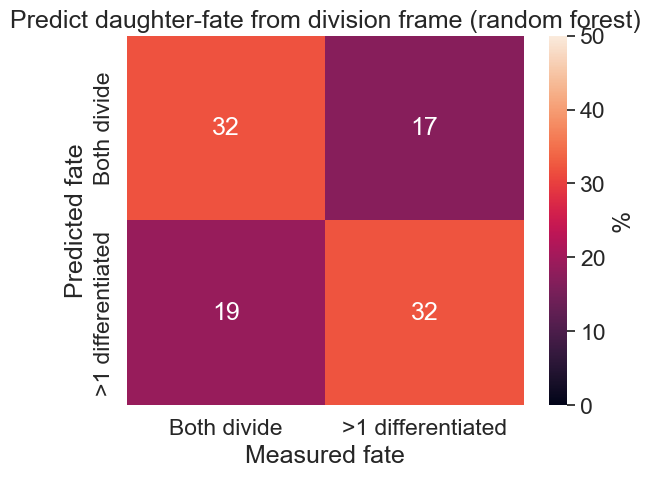

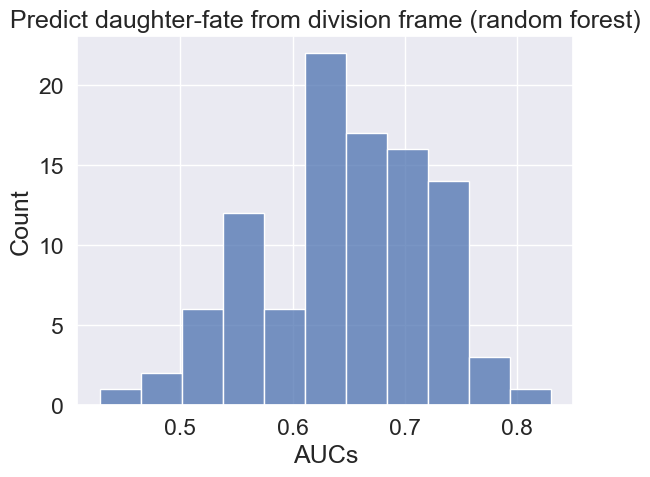

In [173]:
# linear model

from sklearn.linear_model import LogisticRegression

X_transformed = ppca.transform()
top50_ppca = pd.DataFrame(X_transformed,
                         columns=pd.MultiIndex.from_product([['PC'+str(i) for i in range(X_transformed.shape[1])],['Measurement']]) )
top50_ppca[feature2predict,'Meta'] = divisions[feature2predict,'Meta'].values

predictions,models = predict_feature(top50_ppca, LogisticRegression(), feature2predict,Niter=100)

# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1.5)  # crazy big
plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

print(AUCs.mean())

<Axes: >

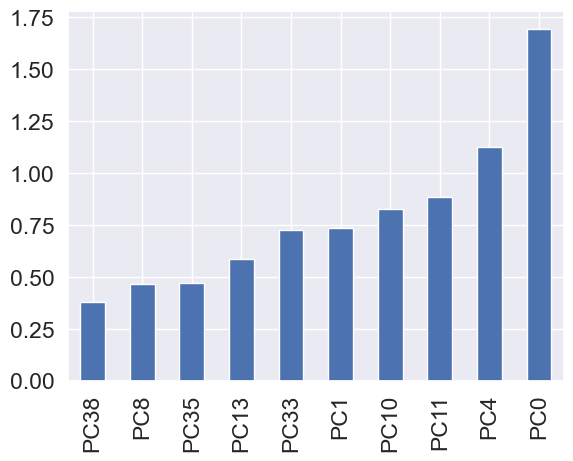

In [35]:
pca_logit_coeffs = pd.Series(np.stack([np.squeeze(m[1].coef_) for m in models]).mean(axis=0),
                             ['PC'+str(i) for i in range(X_transformed.shape[1])] )
pca_logit_coeffs.abs().sort_values().tail(10).plot.bar()

<Axes: >

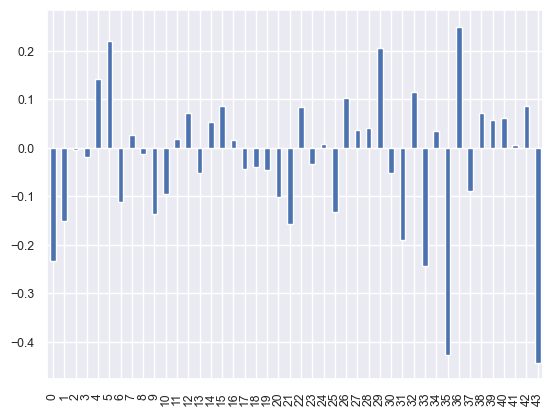

In [182]:
sb.set(font_scale=.8)  # crazy big
components.loc['Relative Basal area'].plot.bar()

In [183]:
components[0].sort_values()

Name
Relative Total H2B intensity                     -0.298108
Relative cyto_shcoeffs_surface_area              -0.292609
Relative cyto_shcoeffs_L0M0C                     -0.291763
Relative Cell volume                             -0.283318
Relative Total FUCCI intensity                   -0.242734
Relative Middle area                             -0.241882
Relative Axial component                         -0.236082
Relative Basal area                              -0.233598
Relative nuc_shcoeffs_surface_area               -0.233531
Relative Nuclear volume                          -0.225298
Relative nuc_shcoeffs_L0M0C                      -0.211762
Basal area                                       -0.204001
cyto_shcoeffs_L0M0C                              -0.192696
Axial component                                  -0.180991
Nuclear volume                                   -0.130078
Mean curvature                                   -0.084436
cyto_shcoeffs_L1M0C                              -0

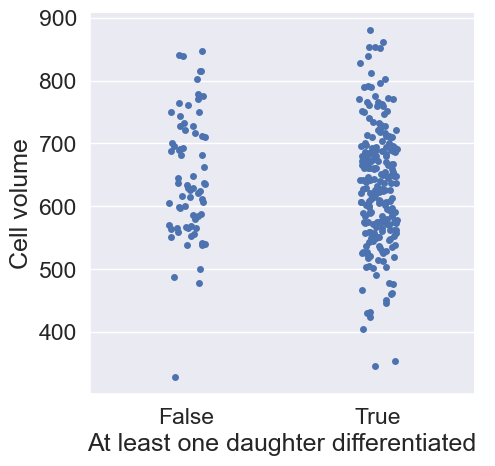

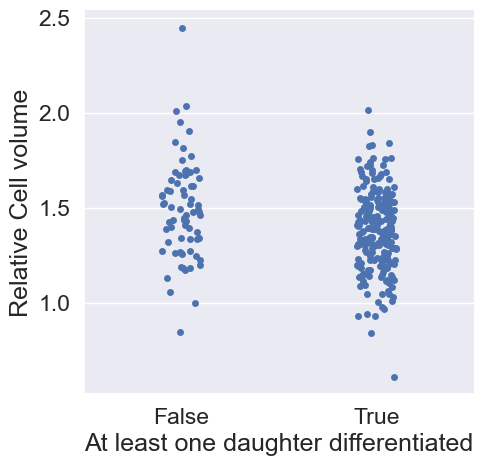

In [178]:
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Cell volume')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Cell volume')

### RFE

In [179]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

# optimal features: 2
Index(['cyto_shcoeffs_L3M0C', 'Relative Height to BM'], dtype='object', name='Name')


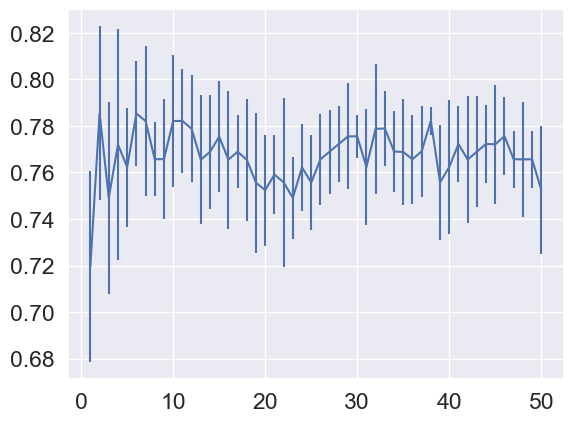

In [64]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])

print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)

## 2. ExtraTreesClassifier

In [143]:
# Run classifier
# axis0: observation axis1: prediction

predictions,models = predict_feature(divisions, ensemble.ExtraTreesClassifier(), feature2predict,Niter=1000)


100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.46it/s]


Text(0.5, 0, 'AUCs')

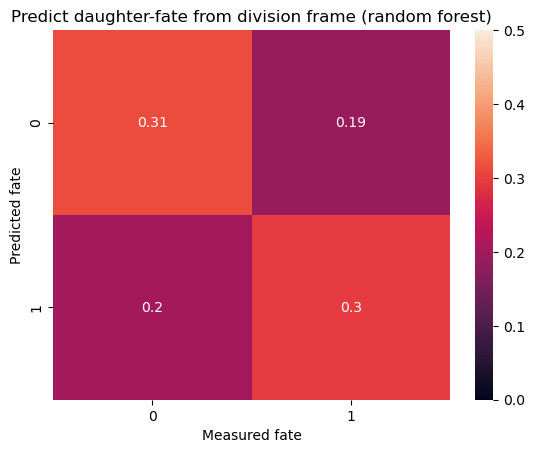

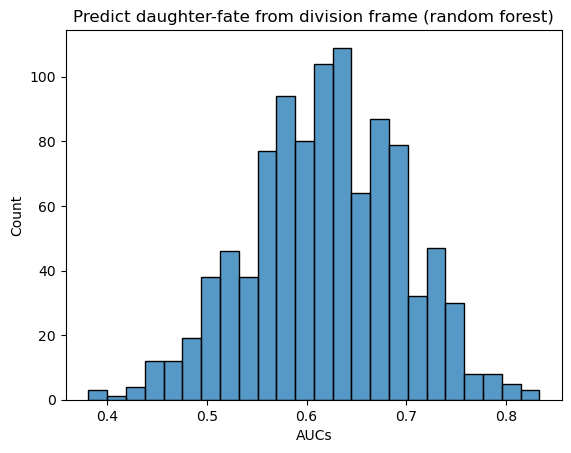

In [144]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
# plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
# plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

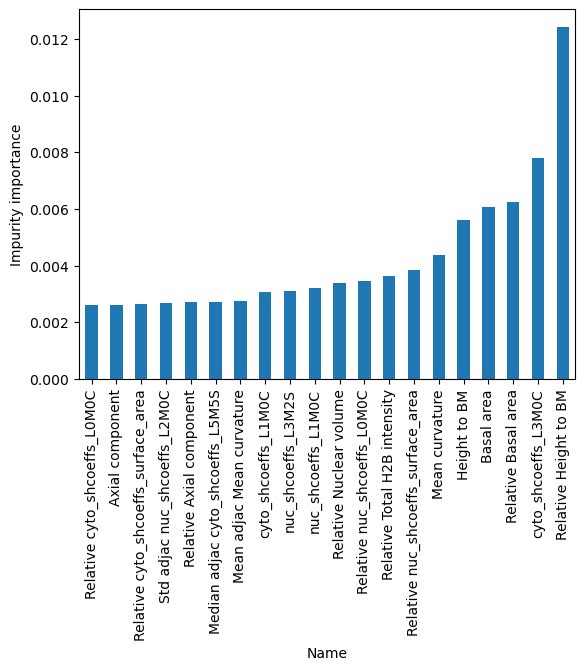

In [145]:
feat_names = divisions.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,feat_names[m[1].get_support()]] = m[2].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()

plt.ylabel('Impurity importance')

In [146]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.ExtraTreesClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

# optimal features: 9
Index(['Basal area', 'Height to BM', 'cyto_shcoeffs_L3M0C',
       'nuc_shcoeffs_L3M2S', 'Median adjac nuc_shcoeffs_L5M2S',
       'Min adjac Planar component 1', 'Relative Total H2B intensity',
       'Relative Basal area', 'Relative Height to BM'],
      dtype='object', name='Name')


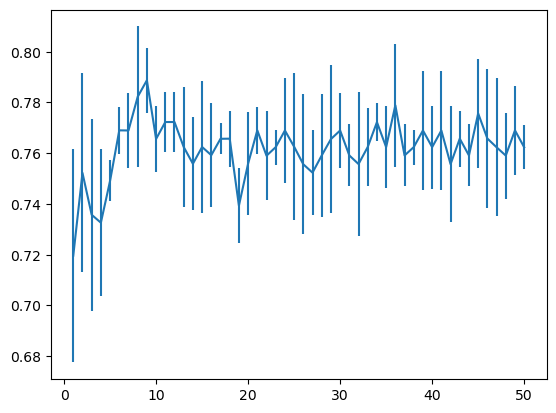

In [148]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])

print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)


In [21]:
results.ranking_[X.columns == 'Mean curvature']

array([1])

## Misc: visualizations

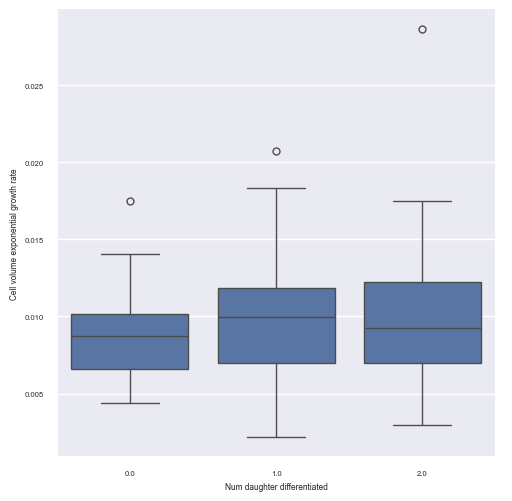

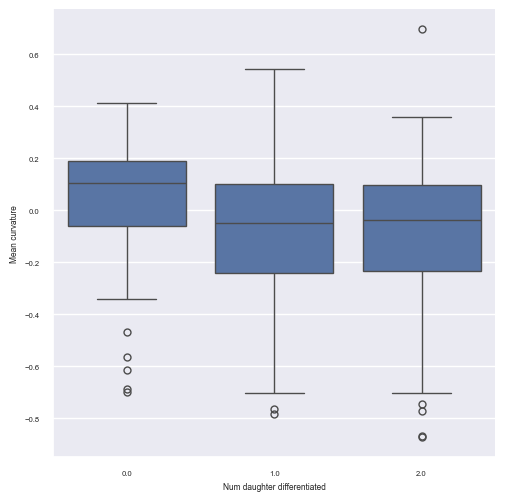

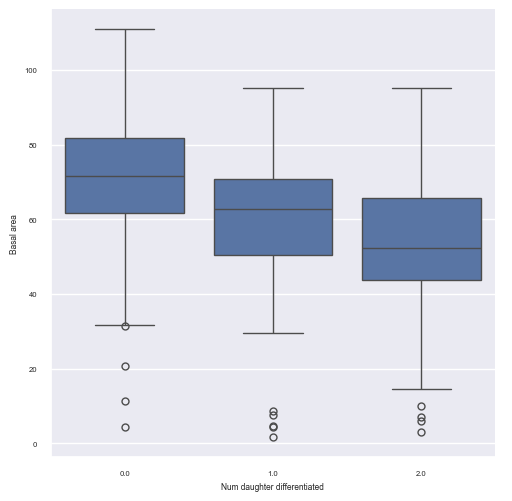

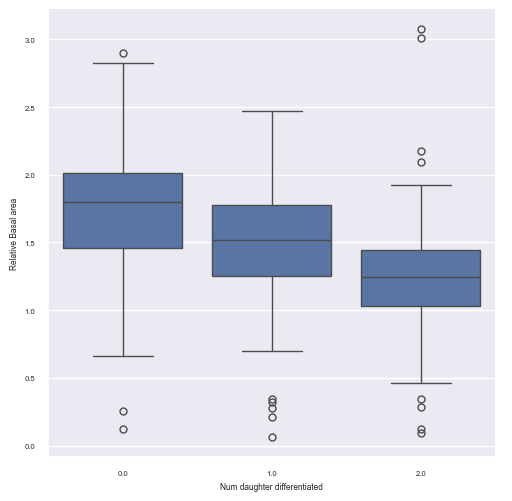

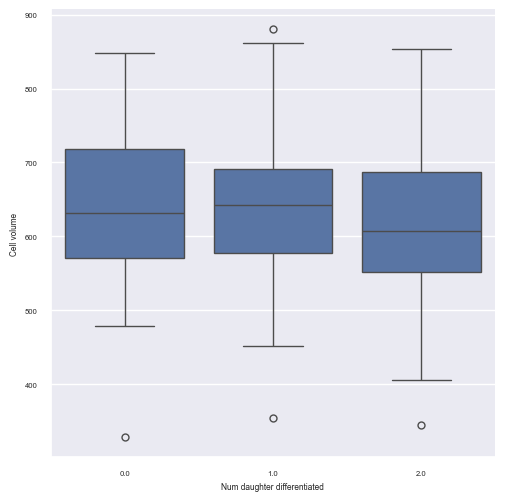

In [89]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell volume exponential growth rate',kind='box')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Mean curvature',kind='box')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Basal area',kind='box')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Relative Basal area',kind='box')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell volume',kind='box')

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165
